## Лабораторна робота №2
### Адаптивні методи бінаризації
Виконав студент групи ФІ-31 Дремко Олександр

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

## Функції

Конвертація зображення в ч/б

In [2]:
def rgb_to_grayscale(image):
    return np.dot(image[..., :3], [0.36, 0.53, 0.11]).astype(np.uint8)

Бінаризація методом Отсу (Лабораторна робота №1)

In [3]:
# Функція для підрахунку гістограм (Підраховуємо кількість пікселів кожної інтенсивності (0-255))
def calculate_histogram(grayscale_image):
    histogram = np.zeros(256)
    for pixel in grayscale_image.flatten():
        histogram[pixel] += 1
    return histogram

# Реалізація методу Отсу
def otsu_binarization(grayscale_image):
    
    histogram = calculate_histogram(grayscale_image) # Кількість пікселів для кожної інтенсивності
    total_pixels = grayscale_image.size  # Загальна кількість пікселів
    sum_total = np.dot(np.arange(256), histogram)  # Сума всіх інтенсивностей пікселів
    
    sum_bg = 0  # Сума інтенсивностей для фону
    weight_bg = 0  # Вага фону (кількість пікселів фону)
    max_variance = 0  # Максимальна міжкласова дисперсія
    threshold = 0  # Знайдений поріг

    weight_fg = 0  # Вага переднього плану (кількість пікселів об'єкта)

    for i in range(256):
        weight_bg += histogram[i]  # Кількість пікселів у фоні
        if weight_bg == 0:
            continue

        weight_fg = total_pixels - weight_bg  # Кількість пікселів у передньому плані
        if weight_fg == 0:
            break

        sum_bg += i * histogram[i]  # Сума інтенсивностей фону
        mean_bg = sum_bg / weight_bg  # Середня інтенсивність фону
        mean_fg = (sum_total - sum_bg) / weight_fg  # Середня інтенсивність переднього плану

        # Обчислюємо міжкласову дисперсію
        variance_between = weight_bg * weight_fg * (mean_bg - mean_fg) ** 2

        # Якщо знайдено більшу дисперсію, оновлюємо поріг
        if variance_between > max_variance:
            max_variance = variance_between
            threshold = i

    # Бінаризація зображення за знайденим порогом
    otsu = (grayscale_image >= threshold).astype(np.uint8) * 255

    return otsu

Бінаризація методом Ніблека

In [4]:
# n розмір локального вікна (непарне число)
# k чутливість методу

def niblack_binarization(grayscale_image, n, k):
    
    # Розміри зображення
    image_height, image_width = grayscale_image.shape
    
    # Копія оригінального зображення для збереження результатів
    niblack = grayscale_image.copy()
    
    # Радіус локального вікна (скільки пікселів у кожну сторону від центру)
    window_radius = (n - 1) // 2

    # Обробка кожного пікселя, окрім країв, де немає достатньо сусідніх пікселів для формування вікна
    for row in range(window_radius, image_height - window_radius):
        for col in range(window_radius, image_width - window_radius):

            # Витягуємо локальний блок (вікно) розміром n x n навколо поточного пікселя
            local_window = grayscale_image[row - window_radius:row + window_radius + 1, col - window_radius:col + window_radius + 1]

            # Розрахунок середнього значення інтенсивності в локальному вікні
            local_mean = np.mean(local_window)

            # Розрахунок стандартного відхилення інтенсивності в локальному вікні
            local_std = np.std(local_window)

            # Розрахунок порогу для поточного пікселя
            local_threshold = local_mean + k * local_std

            # Застосування порогу до поточного пікселя
            if grayscale_image[row, col] < local_threshold:
                niblack[row, col] = 0  # Піксель вважається фоновим
            else:
                niblack[row, col] = 255  # Піксель вважається об'єктом

    return niblack

Бінаризація методом Саувола

In [5]:
# n розмір локального вікна (непарне число)
# R Динамічний діапазон стандартного відхилення інтенсивностей
# k коефіцієнт впливу стандартного відхилення

def sauvola_binarization(grayscale_image, n, R, k):
    
    # Розміри зображення
    image_height, image_width = grayscale_image.shape
    
    # Копія оригінального зображення для збереження результатів
    sauvola = grayscale_image.copy()
    
    # Радіус локального вікна (скільки пікселів у кожну сторону від центру)
    window_radius = (n - 1) // 2

    # Обробка кожного пікселя, окрім країв
    for row in range(window_radius, image_height - window_radius):
        for col in range(window_radius, image_width - window_radius):
            
            # Витягуємо локальне вікно розміром n x n навколо поточного пікселя
            local_window = grayscale_image[row - window_radius:row + window_radius + 1, col - window_radius:col + window_radius + 1]

            # Розрахунок середнього значення інтенсивності в локальному вікні
            local_mean = np.mean(local_window)

            # Розрахунок стандартного відхилення інтенсивності в локальному вікні
            local_std = np.std(local_window)

            # Розрахунок порогу для поточного пікселя за формулою Sauvola
            local_threshold = local_mean * (1 - k * (1 - (local_std / R)))

            # Застосування порогу до поточного пікселя
            if grayscale_image[row, col] < local_threshold:
                sauvola[row, col] = 0  # Піксель вважається фоновим
            else:
                sauvola[row, col] = 255  # Піксель вважається об'єктом

    return sauvola

Бінаризація методом Крістіана

In [6]:
# n розмір локального вікна (непарне число)
# k коефіцієнт впливу контрасту та мінімального значення інтенсивності

def christians_binarization(grayscale_image, n, k):
    
    # Розміри зображення
    image_height, image_width = grayscale_image.shape

    # Копія оригінального зображення для збереження результатів
    christian = grayscale_image.copy()

    # Мінімальна інтенсивність у зображенні
    global_min_intensity = np.min(grayscale_image)

    # Максимальне стандартне відхилення у всьому зображенні
    max_std_dev = 0

    # Пошук максимального стандартного відхилення в локальних вікнах
    half_window = n // 2
    for row in range(half_window, image_height - half_window):
        for col in range(half_window, image_width - half_window):
            
            # Витягуємо локальний блок (вікно) розміром n x n
            local_window = grayscale_image[row - half_window:row + half_window + 1, col - half_window:col + half_window + 1]

            # Обчислюємо стандартне відхилення в локальному вікні
            local_std = np.std(local_window)

            # Оновлюємо максимальне стандартне відхилення
            if local_std > max_std_dev:
                max_std_dev = local_std

    # Радіус локального вікна
    window_radius = (n - 1) // 2

    # Обробка кожного пікселя
    for row in range(window_radius, image_height - window_radius):
        for col in range(window_radius, image_width - window_radius):

            # Витягуємо локальний блок (вікно) розміром n x n
            local_window = grayscale_image[row - window_radius:row + window_radius + 1, col - window_radius:col + window_radius + 1]

            # Розрахунок середнього значення інтенсивності в локальному вікні
            local_mean = np.mean(local_window)

            # Розрахунок стандартного відхилення інтенсивності в локальному вікні
            local_std = np.std(local_window)

            # Розрахунок локального порогу за формулою Christian
            local_threshold = ((1 - k) * local_mean + k * global_min_intensity + k * (local_std / max_std_dev) * (local_mean - global_min_intensity))

            # Застосування порогу до поточного пікселя
            if grayscale_image[row, col] < local_threshold:
                christian[row, col] = 0  # Піксель вважається фоновим
            else:
                christian[row, col] = 255  # Піксель вважається об'єктом

    return christian

Таблиця з порівнянням результатів роботи різних методів бінаризації

In [7]:
def СomparisonTable(image_path, nb_n, nb_k, sau_n, sau_R, sau_k, chr_n, chr_k):

    image = cv2.imread(image_path)

    # Перетворення зображення з BGR у RGB (оскільки OpenCV завантажує в форматі BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Виконуємо обробку для кожного методу
    grayscale_image = rgb_to_grayscale(image)
    otsu_result = otsu_binarization(grayscale_image)
    niblack_result = niblack_binarization(grayscale_image, nb_n, nb_k)
    sauvola_result = sauvola_binarization(grayscale_image, sau_n, sau_R, sau_k)
    christians_result = christians_binarization(grayscale_image, chr_n, chr_k)

    fig, axs = plt.subplots(1, 5, figsize=(18, 5))

    # Відображення зображень
    axs[0].imshow(grayscale_image, cmap="gray")
    axs[0].set_title("Grayscale")
    axs[0].axis('off')

    axs[1].imshow(otsu_result, cmap="gray")
    axs[1].set_title("Otsu")
    axs[1].axis('off')

    axs[2].imshow(niblack_result, cmap="gray")
    axs[2].set_title("Niblack")
    axs[2].axis('off')

    axs[3].imshow(sauvola_result, cmap="gray")
    axs[3].set_title("Sauvola")
    axs[3].axis('off')

    axs[4].imshow(christians_result, cmap="gray")
    axs[4].set_title("Christians")
    axs[4].axis('off')

    plt.tight_layout()
    plt.show()

    # Збереження результатів
    output_dir = "output_images"
    os.makedirs(output_dir, exist_ok=True)
    
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    
    methods = {
        "grayscale": grayscale_image,
        "otsu": otsu_result,
        "niblack": niblack_result,
        "sauvola": sauvola_result,
        "christians": christians_result
        }
    
    for method, result in methods.items():
        output_path = os.path.join(output_dir, f"{base_filename}_{method}.png")
        cv2.imwrite(output_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))


## Використаня

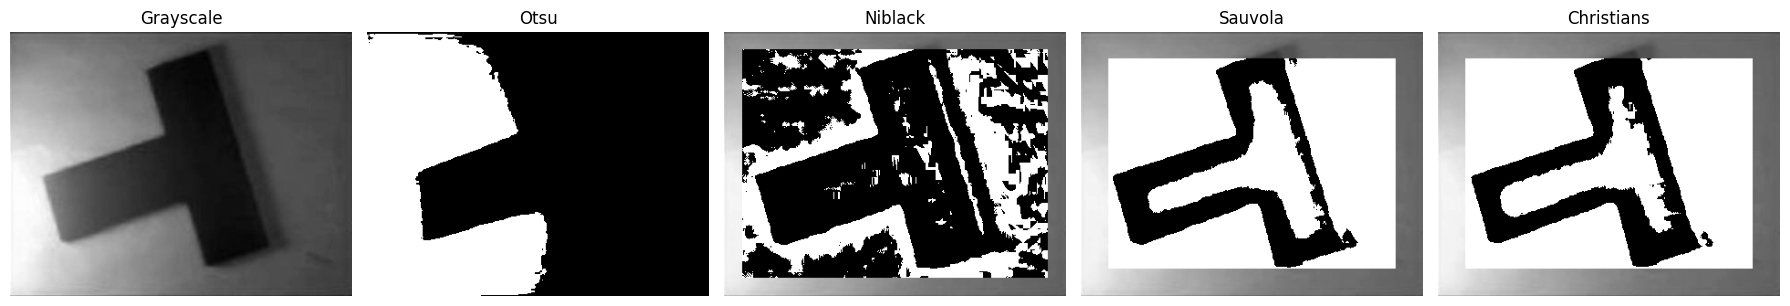

In [8]:
image_path = "1o.png"

# Налаштування
nb_n, nb_k = 41, 0.3
sau_n, sau_R, sau_k = 61, 32, 0.15
chr_n, chr_k = 61, 0.3

СomparisonTable(image_path, nb_n, nb_k, sau_n, sau_R, sau_k, chr_n, chr_k)

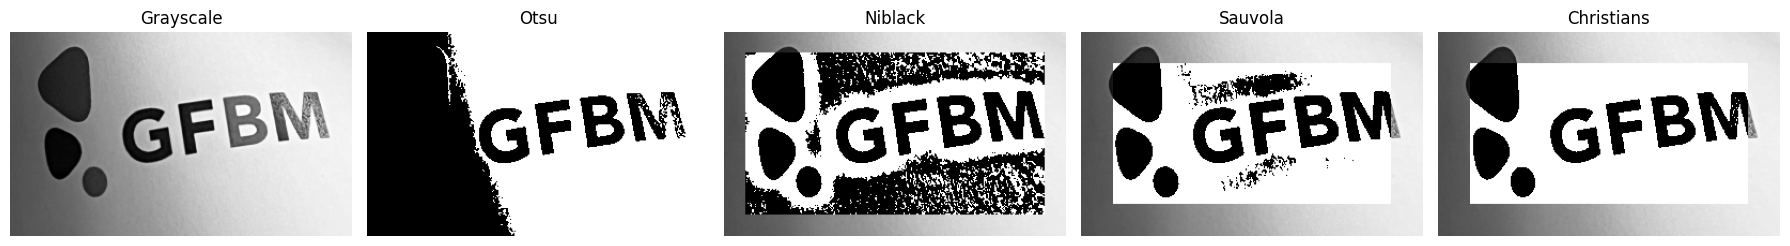

In [9]:
image_path = "2o.png"

# Налаштування
nb_n, nb_k = 41, 0.3
sau_n, sau_R, sau_k = 61, 32, 0.15
chr_n, chr_k = 61, 0.3

СomparisonTable(image_path, nb_n, nb_k, sau_n, sau_R, sau_k, chr_n, chr_k)

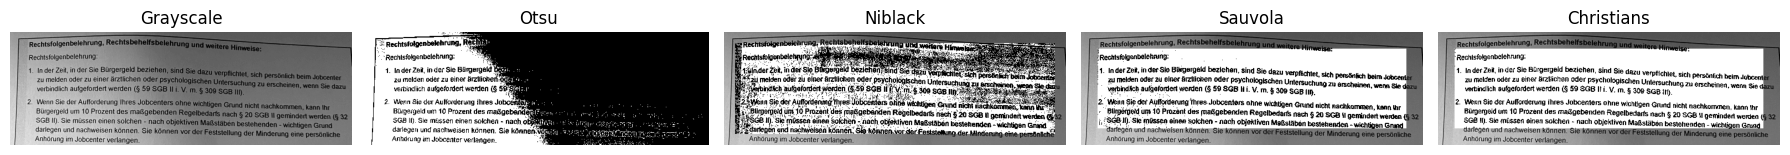

In [10]:
image_path = "1t.png"

# Налаштування
nb_n, nb_k = 41, 0.3
sau_n, sau_R, sau_k = 61, 32, 0.15
chr_n, chr_k = 61, 0.3

СomparisonTable(image_path, nb_n, nb_k, sau_n, sau_R, sau_k, chr_n, chr_k)

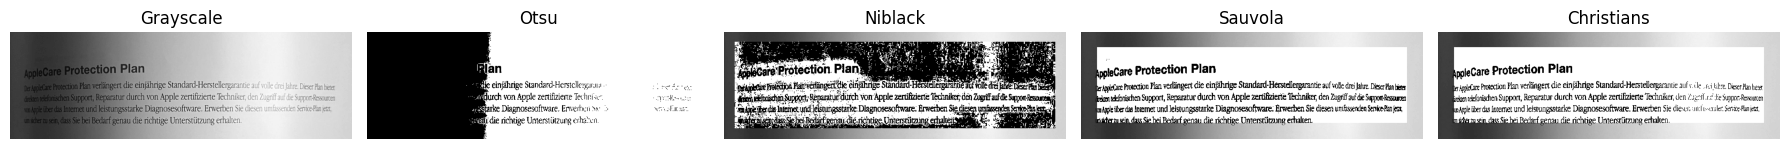

In [11]:
image_path = "2t.png"

# Налаштування
nb_n, nb_k = 41, 0.3
sau_n, sau_R, sau_k = 61, 32, 0.15
chr_n, chr_k = 61, 0.3

СomparisonTable(image_path, nb_n, nb_k, sau_n, sau_R, sau_k, chr_n, chr_k)